In [26]:
import pandas as pd
from google.colab import drive
import os

drv = drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
# Data Prep from Tangh_750.csv file:
# Data Prep from Tangh_750.csv file:
import numpy as np
import pandas as pd
import os

df_neg = pd.read_csv(os.path.join(root_path, 'neg_tanh.csv'),header=None).iloc[:,:]
df_pos = pd.read_csv(os.path.join(root_path,'tangh_750.csv'),header=None).iloc[:-1,:]
neg_vals = df_neg.values
pos_vals = df_pos.values

neg_vals[0,:] = 0
# inverst up side down
neg_vals = np.flipud(neg_vals)
# skip first one as it is present in negatives
pos_vals = pos_vals[1:,:]
conc = np.concatenate([neg_vals,pos_vals])

colx1 = np.zeros(conc.shape[0] + 1)
colx2 = np.zeros(conc.shape[0] + 1)
colx1[1:] = conc[:,0]
colx2[:-1] = conc[:,0]

colx1[0] = -1000
colx2[-1] = 1000
print(colx1.shape)
print(conc.shape)
coly = np.zeros(conc.shape[0] + 1)
coly[1:-1] = conc[1:,1]
coly[-1] = 1
coly[0] = -1
print(coly.shape)
df = pd.DataFrame({'lb':colx1,'ub':colx2,'val':coly})
df.to_csv(os.path.join(root_path,'lower_uppers_val_shakib.csv'))

for c1,c2,cy in zip(colx1,colx2,coly):
    print(c1,' ',c2,' ',cy)

(103,)
(102, 2)
(103,)
-1000.0   -0.00075   -1.0
-0.00075   -0.000735   -1.077621335
-0.000735   -0.00072   -1.075966609
-0.00072   -0.000705   -1.07427064
-0.000705   -0.00069   -1.072531354
-0.00069   -0.000675   -1.070746517
-0.000675   -0.00066   -1.068913721
-0.00066   -0.000645   -1.067030359
-0.000645   -0.00063   -1.065093611
-0.00063   -0.000615   -1.063100416
-0.000615   -0.0006   -1.061047441
-0.0006   -0.000585   -1.058931055
-0.000585   -0.00057   -1.056747286
-0.00057   -0.000555   -1.054491781
-0.000555   -0.00054   -1.052159753
-0.00054   -0.000525   -1.049745928
-0.000525   -0.00051   -1.047244467
-0.00051   -0.000495   -1.044648892
-0.000495   -0.00048   -1.041951984
-0.00048   -0.000465   -1.03914567
-0.000465   -0.00045   -1.036220882
-0.00045   -0.000435   -1.033167387
-0.000435   -0.00042   -1.029973581
-0.00042   -0.000405   -1.026626236
-0.000405   -0.00039   -1.023110181
-0.00039   -0.000375   -1.019407909
-0.000375   -0.00036   -1.015499074
-0.00036   -0.00034

In [28]:
import tensorflow as tf

print(tf.__version__)
from tensorflow.keras.layers import Dense,Dropout, Activation,Input,GaussianNoise
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from keras.datasets import fashion_mnist
from IPython.display import SVG
import os
import csv
from tensorflow.keras import models

NUM_ROWS = 28
NUM_COLS = 28
NUM_CLASSES = 10
BATCH_SIZE = 128
EPOCHS = 10

def data_summary(X_train, y_train, X_test, y_test):
    """Summarize current state of dataset"""
    print('Train images shape:', X_train.shape)
    print('Train labels shape:', y_train.shape)
    print('Test images shape:', X_test.shape)
    print('Test labels shape:', y_test.shape)
    print('Train labels:', y_train)
    print('Test labels:', y_test)

# # tanh_list = list(csv.reader(open(os.path.join(root_path,'tangh_750.csv'))))
# tanh_list = tanh_list[:-1]

# new_list = []
# for l1 in tanh_list:
#     tmp = []
#     for li in l1:
#         print(li)
#         tmp.append(float(li))
#     new_list.append(tmp)        
# tanh_list_tf=tf.convert_to_tensor(new_list,dtype=tf.float32)
# print(tanh_list_tf)


colx1_tf = tf.convert_to_tensor(colx1*10000,dtype=tf.float32)
colx2_tf = tf.convert_to_tensor(colx2*10000,dtype=tf.float32)
coly_tf = tf.convert_to_tensor(coly,dtype=tf.float32)

def log1pexp(x):
  e = tf.exp(x)
  def grad(dy):
    return dy * (1 - 1 / (1 + e))
  return tf.math.log(1 + e), grad

@tf.custom_gradient
#@tf.function
def proposed_tanh(x):
    print(x)
    print(x.shape)
    x = x[...,tf.newaxis]
    print(x.shape)
    global colx1_tf,colx2_tf,coly_tf

    lb = colx1_tf <= x
    ub = x < colx2_tf

    res = tf.dtypes.cast(tf.logical_and(lb,ub),dtype=tf.float32)
    print(res.shape,coly_tf.shape,'eeee')
    y = tf.multiply(res,coly_tf)
    y = tf.reduce_sum(y,axis=-1)

    def grad(dx):
      return dx * tf.where(tf.math.abs(y)<1,1 - y * y,0)
    return y,grad      
	
#np_proposed_tanh = np.vectorize(proposed_tanh)
#get_custom_objects().update({'proposed_tanh': Activation(proposed_tanh)})



"""Load and prepare data"""

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Check state of dataset
data_summary(X_train, y_train, X_test, y_test)

# Reshape data

X_train = X_train.reshape((X_train.shape[0], NUM_ROWS * NUM_COLS))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], NUM_ROWS * NUM_COLS))
X_test = X_test.astype('float32') / 255

# Guassian Noise here
noise = False
if noise:
    mu, sigma = 0, 0.1 
    noise_x_tr = np.random.normal(mu, sigma, X_train.shape)
    X_train = X_train + noise_x_tr



#Salt&Pepper Noise
salt_n_pepper = False
if salt_n_pepper:
    noise_factor = 0.2
    #np.random.normal => random means to obtain random samples
    #normal means normal or gaussian distribution, 
    #i.e. random sample from gaussian distribution
    X_train = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)  
    X_test = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

    # to make values in the range of 0 to 1, 
    #if values < 0 then they will be equal to 0 and 
    #if values > 1 then they will be equal to 1.
    X_train = np.clip(X_train, 0., 1.)   
    X_test = np.clip(X_test, 0., 1.)

# Categorically encode labels
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

# Check state of dataset
data_summary(X_train, y_train, X_test, y_test)


"""Build and train neural network"""

# Build neural network
model = models.Sequential()
#get_custom_objects().update({'proposed_tanh': Activation(proposed_tanh)})
#Adding Gaussian Noise
model.add(Input(shape=(NUM_ROWS * NUM_COLS,)))
#model.add(GaussianNoise(stddev=1))
#end of Gaussian Noise
model.add(Dense(784, activation='tanh'))#, input_shape=(NUM_ROWS * NUM_COLS,)))
model.add(Dropout(0.5))
#model.add(Dense(392, activation=proposed_tanh))
#model.add(Dropout(0.5))
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.5))
#model.add(Dense(64, activation=proposed_tanh))
#model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

"""Summarize and visualize the model"""

# Summary of neural network
model.summary()

# Compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history1=model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          #callbacks=[plot_losses],
          verbose=1,
          validation_data=(X_test, y_test))

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])




# Output network visualization
#SVG(model_to_dot(model).create(prog='dot', format='svg'))


2.3.0
Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)
Train labels: [5 0 4 ... 5 6 8]
Test labels: [7 2 1 ... 4 5 6]
Train images shape: (60000, 784)
Train labels shape: (60000, 10)
Test images shape: (10000, 784)
Test labels shape: (10000, 10)
Train labels: [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Test labels: [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 784)               615440    
_________________________________________________________________
dropout_10 (Dropout)         (None, 784)          

In [29]:
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
from typing import *
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

now = datetime.now().strftime("%d-%m-%Y:%H")

def visualize(history: Dict, save_plot: bool = True, save_dir: str = None):
    """Visualize training history of model
    
    Parameters
    ----------
    history : Dict
        model.fit history
    save_plot : bool, optional
        save plot to hard disk, by default True
    save_dir : str, optional
        path to save plot, by default None
    """
    df = pd.DataFrame(history)
    sns.set_style('whitegrid')
    plt.figure(figsize=(15, 10))
    plt.title('Model Performance')
    plt.xlabel('Epochs #')
    plt.ylabel('Accuracy/Loss')
    sns.lineplot(data=df, markers=True, dashes=False)    
    plt.show()

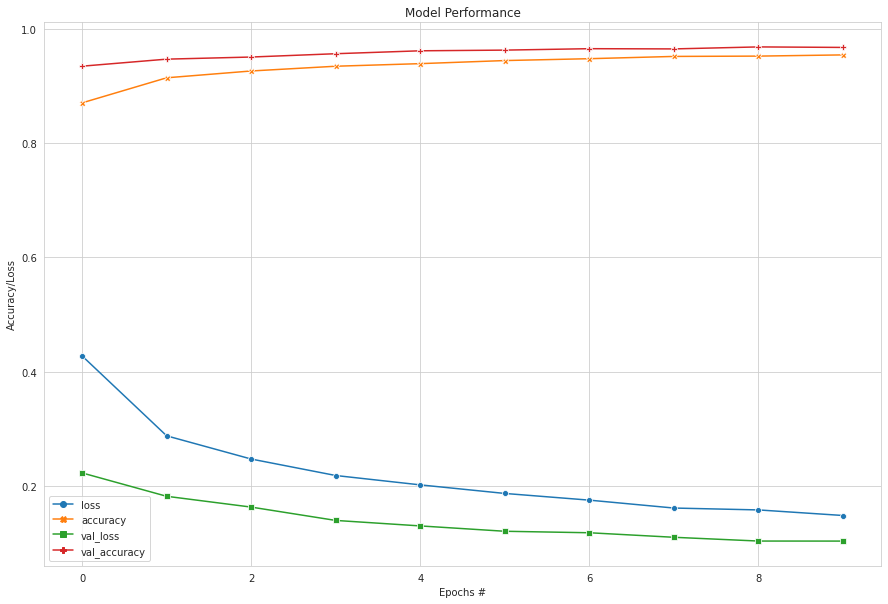

In [31]:
visualize(
    history=history1.history,
)
import pandas as pd

df = pd.DataFrame(history1.history)
df.to_csv(os.path.join(root_path,"tanh5_mnist.csv"))


## Resnet 20

Cifar-10 Dataset Loader

In [32]:
# Load data
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
BATCH_SIZE = 512

(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# Check state of dataset
data_summary(X_train, y_train, X_test, y_test)

# Reshape data

X_train = X_train.reshape((X_train.shape[0], 32,32,3))
X_train = X_train.astype('float32') / 255
X_test = X_test.reshape((X_test.shape[0], 32,32,3))
X_test = X_test.astype('float32') / 255

# Guassian Noise here
noise = False
if noise:
    mu, sigma = 0, 0.1 
    noise_x_tr = np.random.normal(mu, sigma, X_train.shape)
    X_train = X_train + noise_x_tr


salt_n_pepper = False
if salt_n_pepper:
    noise_factor = 0.2
    #np.random.normal => random means to obtain random samples
    #normal means normal or gaussian distribution, 
    #i.e. random sample from gaussian distribution
    X_train = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)  
    X_test = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

    # to make values in the range of 0 to 1, 
    #if values < 0 then they will be equal to 0 and 
    #if values > 1 then they will be equal to 1.
    X_train = np.clip(X_train, 0., 1.)   
    X_test = np.clip(X_test, 0., 1.)    

Train images shape: (50000, 32, 32, 3)
Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)
Train labels: [[19]
 [29]
 [ 0]
 ...
 [ 3]
 [ 7]
 [73]]
Test labels: [[49]
 [33]
 [72]
 ...
 [51]
 [42]
 [70]]


Visualizer:

In [33]:
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
from typing import *
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

now = datetime.now().strftime("%d-%m-%Y:%H")

def visualize(history: Dict, save_plot: bool = True, save_dir: str = None):
    """Visualize training history of model
    
    Parameters
    ----------
    history : Dict
        model.fit history
    save_plot : bool, optional
        save plot to hard disk, by default True
    save_dir : str, optional
        path to save plot, by default None
    """
    df = pd.DataFrame(history)
    sns.set_style('whitegrid')
    plt.figure(figsize=(15, 10))
    plt.title('Model Performance')
    plt.xlabel('Epochs #')
    plt.ylabel('Accuracy/Loss')
    sns.lineplot(data=df, markers=True, dashes=False)    
    plt.show()



Resnet Builder:

In [34]:
from typing import *

import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import *
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, BatchNormalization, \
    AveragePooling2D, Flatten, Dropout
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100

from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


# Identity Block or Residual Block or simply Skip Connector
def residual_block(X, num_filters: int, stride: int = 1, kernel_size: int = 3,
                   activation: str = 'relu', bn: bool = True, conv_first: bool = True):
    """
    Parameters
    ----------
    X : Tensor layer
        Input tensor from previous layer
    num_filters : int
        Conv2d number of filters
    stride : int by default 1
        Stride square dimension
    kernel_size : int by default 3
        COnv2D square kernel dimensions
    activation: str by default 'relu'
        Activation function to used
    bn: bool by default True
        To use BatchNormalization
    conv_first : bool by default True
        conv-bn-activation (True) or bn-activation-conv (False)
    """
    conv_layer = Conv2D(num_filters,
                        kernel_size=kernel_size,
                        strides=stride,
                        padding='same',
                        kernel_regularizer=l2(1e-4))
    # X = input
    if conv_first:
        X = conv_layer(X)
        if bn:
            X = BatchNormalization()(X)
        if activation is not None:
            X = Activation(activation)(X)
            X = Dropout(0.2)(X)
    else:
        if bn:
            X = BatchNormalization()(X)
        if activation is not None:
            X = Activation(activation)(X)
        X = conv_layer(X)

    return X


def build_resnet_model(input_shape: Tuple[int, int, int],
                       depth: int,
                       num_classes: int):
    """
    ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as bottleneck layer.
    First shortcut connection per layer is 1 x 1 Conv2D. Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (down sampled) by a convolution layer with strides=2,
    while the number of filter maps is doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Parameters
    ----------
    input_shape : tuple
        3D tensor shape of input image
    depth : int
        Number of core Convolution layer. Depth should be 9n+2 (eg 56 or 110), where n = desired depth
    num_classes : int
        No of classes
    Returns
    -------
    model: Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110')

    # Model definition
    num_filters_in = 32
    num_res_block = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)

    # ResNet V2 performs Conv2D on X before spiting into two path
    X = residual_block(X=inputs, num_filters=num_filters_in, conv_first=True)

    # Building stack of residual units
    for stage in range(3):
        for unit_res_block in range(num_res_block):
            activation = 'relu'
            bn = True
            stride = 1
            # First layer and first stage
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if unit_res_block == 0:
                    activation = None
                    bn = False
                # First layer but not first stage
            else:
                num_filters_out = num_filters_in * 2
                if unit_res_block == 0:
                    stride = 2

            # bottleneck residual unit
            y = residual_block(X,
                               num_filters=num_filters_in,
                               kernel_size=1,
                               stride=stride,
                               activation=activation,
                               bn=bn,
                               conv_first=False)
            y = residual_block(y,
                               num_filters=num_filters_in,
                               conv_first=False)
            y = residual_block(y,
                               num_filters=num_filters_out,
                               kernel_size=1,
                               conv_first=False)
            if unit_res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                X = residual_block(X=X,
                                   num_filters=num_filters_out,
                                   kernel_size=1,
                                   stride=stride,
                                   activation=None,
                                   bn=False)
            X = tf.keras.layers.add([X, y])
        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = AveragePooling2D(pool_size=8)(X)
    y = Flatten()(X)
    y = Dense(512, activation='relu')(y)
    y = BatchNormalization()(y)
    y = Dropout(0.5)(y)

    outputs = Dense(num_classes,
                    activation='softmax')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
from tensorflow.keras.optimizers import Adam

# 1. Build a complete ResNetV2 model with n no of residual layers with Fully connected layers included
resnet_model = build_resnet_model(
    input_shape=(32, 32, 3),
    depth=20,
    num_classes=100
)

# Number of epochs
eps = 10000

resnet_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(amsgrad=True, decay=0.001/eps),
    metrics=['accuracy']
)


history20 = resnet_model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,

    epochs=eps,
    verbose=1,
    validation_data=(X_test, y_test),
    validation_steps=X_test.shape[0]/BATCH_SIZE
)


Epoch 1/10000
98/98 [==============================] - 36s 372ms/step - loss: 4.5462 - accuracy: 0.0831 - val_loss: 5.4140 - val_accuracy: 0.0100
Epoch 2/10000
98/98 [==============================] - 36s 370ms/step - loss: 3.8576 - accuracy: 0.1667 - val_loss: 6.8504 - val_accuracy: 0.0167
Epoch 3/10000
98/98 [==============================] - 37s 374ms/step - loss: 3.3567 - accuracy: 0.2457 - val_loss: 5.9392 - val_accuracy: 0.0290
Epoch 4/10000
98/98 [==============================] - 37s 375ms/step - loss: 2.9582 - accuracy: 0.3229 - val_loss: 5.5145 - val_accuracy: 0.0565
Epoch 5/10000
98/98 [==============================] - 37s 376ms/step - loss: 2.6561 - accuracy: 0.3841 - val_loss: 4.4335 - val_accuracy: 0.1683
Epoch 6/10000
98/98 [==============================] - 37s 377ms/step - loss: 2.4459 - accuracy: 0.4301 - val_loss: 3.4419 - val_accuracy: 0.2413
Epoch 7/10000
98/98 [==============================] - 37s 378ms/step - loss: 2.2699 - accuracy: 0.4694 - val_loss: 3.3125 -

In [ ]:
visualize(
    history=history20.history,
)

# ResNet-29

In [ ]:
from tensorflow.keras.optimizers import Adam

# 1. Build a complete ResNetV2 model with n no of residual layers with Fully connected layers included
resnet_model = build_resnet_model(
    input_shape=(32, 32, 3),
    depth=29,
    num_classes=100
)

# Number of epochs
eps = 10

resnet_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(amsgrad=True, decay=0.001/eps),
    metrics=['accuracy']
)


history29 = resnet_model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,

    epochs=eps,
    verbose=1,
    validation_data=(X_test, y_test),
    validation_steps=X_test.shape[0]/BATCH_SIZE
)

In [ ]:
visualize(
    history=history29.history,
)

# ResNet38

In [ ]:
from tensorflow.keras.optimizers import Adam

# 1. Build a complete ResNetV2 model with n no of residual layers with Fully connected layers included
resnet_model = build_resnet_model(
    input_shape=(32, 32, 3),
    depth=38,
    num_classes=100
)

# Number of epochs
eps = 10

resnet_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(amsgrad=True, decay=0.001/eps),
    metrics=['accuracy']
)


history38 = resnet_model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,

    epochs=eps,
    verbose=1,
    validation_data=(X_test, y_test),
    validation_steps=X_test.shape[0]/BATCH_SIZE
)

In [ ]:
visualize(
    history=history38.history,
)

# Save to file

In [ ]:
import pandas as pd

df = pd.DataFrame(history20.history)
df.to_csv(os.path.join(root_path,"proposed1_cifar100_20.csv"))

df = pd.DataFrame(history29.history)
df.to_csv(os.path.join(root_path,"proposed1_cifar100_29.csv"))

df = pd.DataFrame(history38.history)
df.to_csv(os.path.join(root_path,"proposed1_cifar100_38.csv"))

# Code Playground